After loading in the mat file to Colab, we then make use of scipy.io to open the mat file and create a variable for the Y features

In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mat_data = 'Tremor_matrix_with_causal_factors_and_prototypes.mat'
mat_contents = sio.loadmat(mat_data)
Y_features = mat_contents['Y_tremor_features_norm'];

Before loading the features into a dataframe and organising them, I first define the relevant functions I will apply to the dataframe. To begin with, for LOOCV I found it convenient to define a losses function. For the kth iteration, this function takes k as the testing set and the rest as the training set and returns the error.

In [2]:
def losses(data, algo, k, column):
    #split into 2 dataframes with k and without it
    data_filtered = data[data[column] != k]
    data_cv = data[data[column] == k]
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=column)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
      
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=column)
    X_train = data_train.drop(columns=[outcomevar])
      
    X_train = np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    # Train the model on training data
    algo.fit(X_train, y_train);
    predictions = algo.predict(X_test)
    prob_predictions = algo.predict_proba(X_test)
    errors = abs(predictions - y_test.values)
    return errors, predictions, prob_predictions, y_test.values

The following code is an adaptation for Python of Bates' R code shown here: https://github.com/stephenbates19/nestedcv/blob/master/R/core.R. It is based off the algorithm detailed in Bates, Hastie, and Tibshinari's https://arxiv.org/pdf/2104.00673.pdf. I had to make some changes for LOOCV as the code relied on making K equal partitions for each fold, and with the case of using IDs there are not 8 equal partitions for each patient. I opted to generalise this for a specific column so I could experiment with nesting on things other than the ID

In [75]:
from scipy import stats

def naive_loocv(data, algo, column, alpha = 0.1):
    """ Naive LOOCV
    Performs Naive Leave One Out Cross Validation on data provided
    Inputs:
    - data A dataframe of features and response variable
    - algo A classification algorithm object, with the attributes fit and predict
    - column The features who's unique values will be used as partitions
    - alpha The error rate. Must be in (0, 0.5)
    Outputs:
    - err_hat Mean of CV prediction errors
    - ci_lo Lower endpoint for CV confidence interval on prediction error 
    - ci_hi Higher endpoint for CV confidence interval on prediction error
    - sd Standard Deviation of the CV prediction errors
    """

    errors = np.array([])
    fig, ax = plt.subplots()
    sensitivity_LOOCV = []
    specificity_LOOCV = []
    balanced_accuracy_LOOCV = []
    thr = []

    #get list for the values to iterate over
    vals = data[column].unique()
    for k in vals:
        #find error with k as testing subject
        error_k, pred_k, pred_prob_k, label_k = losses(data, algo, k, column)
        errors = np.concatenate((errors, error_k))
        
        ind_true = np.where(label_k == 1)
        ind_false = np.where(label_k == 0) 
        fpr, tpr, thresholds = metrics.roc_curve(label_k, pred_prob_k[:,1])
        data_roc = np.vstack((fpr,tpr)).T
        fpr_plot = pd.DataFrame(data=data_roc, columns=["fpr", "tpr"])
        # This is the ROC curve 
        sns.set()
        sns.lineplot(data=fpr_plot,  x="fpr", y="tpr", ax=ax)
        
        balanced_accuracy_LOOCV_temp = (tpr+(1-fpr))/2
        balanced_accuracy_LOOCV.append((tpr+(1-fpr))/2)

        max_val = max(balanced_accuracy_LOOCV_temp.reshape(-1,1))
        ind_max = np.argmax(balanced_accuracy_LOOCV_temp.reshape(-1,1))
        sensitivity_LOOCV.append(tpr[ind_max])
        specificity_LOOCV.append(1 - fpr[ind_max])
        thr.append(thresholds[ind_max])

        print("..." + str(int(k)) + " processing complete")

    #mean error
    err_hat = np.mean(errors)

    #defines the low and high confidence intervals for the error
    ci_lo = np.mean(errors) - stats.norm.ppf(1-alpha/2) * np.std(errors) / np.sqrt(len(data.index))
    ci_hi = np.mean(errors) + stats.norm.ppf(1-alpha/2) * np.std(errors) / np.sqrt(len(data.index))

    #standard deviation of errors
    sd = np.std(errors)
    
    #print specificity and sensitivity
    print("Sensitivity: {} | Specificity: {}".format(np.mean(sensitivity_LOOCV), np.mean(specificity_LOOCV)))

    #dictionary returned of relevant values
    return {'err_hat': err_hat, 'ci_lo': ci_lo, 'ci_hi': ci_hi, "sd": sd}

In [ ]:
def nested_loocv_helper(data, algo, column, alpha = 0.1):
  """ Nested LOOCV helper
  Function to aid Nested LOOCV. Similar to Naive but with additional nesting stage
  Inputs:
  - data A dataframe of features and response variable
  - algo A classification algorithm object, with the attributes fit and predict
  - column The features who's unique values will be used as partitions
  - alpha The error rate. Must be in (0, 0.5)
  Outputs:
  - out-mat Vector of difference statistics with same length as target
  - all_ho_errors Vector of hold-out errors not used in model training
  """

  #define number of folds needed for column 
  vals = data[column].unique()
  K = len(vals)

  #fold 1 iterates through K-1 points, and fold 2 iterates through remainder of list after fold 1
  ho_errors = {}
  #entry i,j is error on fold i when folds i & j are not used for model fitting
  for f1 in range(K-1):
    for f2 in range(f1+1, K):
      ho_errors[(f1,f2)] = losses(data, algo, vals[f1], column)
      ho_errors[(f2,f1)] = losses(data[data[column] != vals[f1]], algo, vals[f2], column)

  #loops over all points in the two folds, except when the values are equal
  out_mat = np.zeros((K, 2))
  for f1 in range(K):
    e_out = losses(data, algo, vals[f1], column)

    e_bar_t = np.array([])
    for f2 in range(K):
      if f1 != f2:
        e_bar_t = np.concatenate((e_bar_t, ho_errors[(f2,f1)]))

    out_mat[f1,0] = np.mean(e_bar_t) - np.mean(e_out)
    out_mat[f1,1] = np.var(e_out) / len(data[data[column] == vals[f1]].index)

  all_ho_errors = np.array([])
  #produces final hold-out error vector for the values computed
  for f1 in range(K-1):
    for f2 in range(f1+1, K):
      all_ho_errors = np.concatenate((all_ho_errors, ho_errors[(f1,f2)], ho_errors[(f2,f1)]))

  #returns dictionary with outputs
  return {"pivots": out_mat, "errs": all_ho_errors}

In [ ]:
import datetime
import math

def nested_loocv(data, algo, column, reps=50, alpha=0.1, bias_reps=None, time=False):
  """ Nested LOOCV
  Performs Nested LOOCV over several reps and computes bias
  Inputs:
  - data A dataframe of features and response variable
  - algo A classification algorithm object, with the attributes fit and predict
  - column The features who's unique values will be used as partitions
  - reps The number of times the algorithm should be repeated, the higher the more accurate it is
  - alpha The error rate. Must be in (0, 0.5)
  - bias_reps The number of repetitions used to calculate the bias
  - time Useful for several repetitions to get an estimate of how long it'll take to run
  Outputs:
  - sd_infl The multiplicative factor needed to correct the interval width
  - err_hat Mean of CV prediction erorrs corrected for bias
  - ci_lo Lower endpoint for CV confidence interval on prediction error 
  - ci_hi Higher endpoint for CV confidence interval on prediction error
  - raw_mean Mean of CV prediction errors without correction for bias
  - bias_est Estimation of bias from Naive LOOCV
  - sd Standard deviation of the prediction errors
  - running_sd_infl Used to evaluate how stable the estimate is and if more replicates are needed
  """

  #number of folds
  K = len(data[column].unique())

  #time estimation
  if time == True:
    t1 = datetime.datetime.now()
    temp = nested_loocv_helper(data, algo, column)
    t2 = datetime.datetime.now()
    print("Estimated time required: {}".format((t2-t1)*reps))

  #runs the algorithm several time appending the results for each repetition
  var_pivots = np.zeros((reps*K, 2))
  ho_errs = np.array([])
  for i in range(reps):
    var_pivots[K*i:K*(i+1)] = nested_loocv_helper(data, algo, column)["pivots"]
    ho_errs = np.concatenate((ho_errs, nested_loocv_helper(data, algo, column)["errs"]))
    print("...{} rep completed!".format(i))

  n_sub = math.floor((len(data[column])) * (K-1) / K)
  #estimation of inflation after each repetition
  ugp_infl = np.sqrt(max(0, np.mean(var_pivots[:,0]**2 - var_pivots[:,1]))) / (np.std(ho_errs) / np.sqrt(n_sub))
  ugp_infl = max(1, min(ugp_infl, np.sqrt(K)))

  #estimate of inflation at each time step
  infl_est2 = np.sqrt(np.maximum(0, np.array([np.mean(var_pivots[:(i+1)*K,0]**2 - var_pivots[:(i+1)*K, 1]) for i in range(reps)]))) / (np.std(ho_errs) / np.sqrt(n_sub))

  #calculates the bias using Naive LOOCV result
  cv_means = np.array([])
  bias_est = 0
  if bias_reps is None:
    bias_reps = math.ceil(reps / 5)
  if bias_reps == 0:
    bias_est = 0
  else:
    for i in range(bias_reps):
      temp = naive_loocv(data, algo, column)
      cv_means = np.append(cv_means, temp["err_hat"])
      print("...{} bias rep completed!".format(i))

    bias_est = (np.mean(ho_errs) - np.mean(cv_means)) * (1 + ((K - 2) / (K))**(1.5))

  pred_est = np.mean(ho_errs) - bias_est
  ci_lo = pred_est - stats.norm.ppf(1-alpha/2) * np.std(ho_errs) / np.sqrt(len(data[column])) * ugp_infl
  ci_hi = pred_est + stats.norm.ppf(1-alpha/2) * np.std(ho_errs) / np.sqrt(len(data[column])) * ugp_infl

  return {"sd_infl": ugp_infl, "err_hat": pred_est, "ci_lo": ci_lo, "ci_hi": ci_hi, "raw_mean": np.mean(ho_errs), "bias_est": bias_est, "sd": np.std(ho_errs), "running_sd_inf1": infl_est2}

In [83]:
def naive_tenfoldcv(data, algo=None, alpha=0.1, mixed_effects = False):
    """ Naive 10-fold CV
    Performs Naive 10-fold Cross Validation on data provided
    Inputs:
    - data A dataframe of features and response variable
    - algo A classification algorithm object, with the attributes fit and predict
    - alpha The error rate. Must be in (0, 0.5)
    Outputs:
    - err_hat Mean of CV prediction errors
    - ci_lo Lower endpoint for CV confidence interval on prediction error 
    - ci_hi Higher endpoint for CV confidence interval on prediction error
    - sd Standard Deviation of the CV prediction errors
    """

    X = data.drop(columns=[outcomevar]).to_numpy()
    y = data[outcomevar].to_numpy()

    fold_id = np.array([i % 10 for i in range(len(data.index))])
    np.random.shuffle(fold_id)

    errors = np.array([])
    fig, ax = plt.subplots()
    sensitivity_10fold = []
    specificity_10fold = []
    balanced_accuracy_10fold = []
    thr = []
    
    for k in range(10):
        if mixed_effects:
            md = Lmer(formula=formula, data=data[fold_id != k], family='binomial')
            md.fit()
            predictions = md.predict(data[fold_id == k])
        else:
            algo.fit(X[fold_id != k], y[fold_id != k])
            predictions = algo.predict(X[fold_id == k])
            pred_prob_k = algo.predict_proba(X[fold_id == k])
            
            ind_true = np.where(y[fold_id == k] == 1)
            ind_false = np.where(y[fold_id == k] == 0) 
            fpr, tpr, thresholds = metrics.roc_curve(y[fold_id == k], pred_prob_k[:,1])
            data_roc = np.vstack((fpr,tpr)).T
            fpr_plot = pd.DataFrame(data=data_roc, columns=["fpr", "tpr"])
            # This is the ROC curve 
            sns.set()
            sns.lineplot(data=fpr_plot,  x="fpr", y="tpr", ax=ax)
        
            balanced_accuracy_10fold_temp = (tpr+(1-fpr))/2
            balanced_accuracy_10fold.append((tpr+(1-fpr))/2)

            max_val = max(balanced_accuracy_10fold_temp.reshape(-1,1))
            ind_max = np.argmax(balanced_accuracy_10fold_temp.reshape(-1,1))
            sensitivity_10fold.append(tpr[ind_max])
            specificity_10fold.append(1 - fpr[ind_max])
            thr.append(thresholds[ind_max])
    
        error_k = abs(predictions - y[fold_id == k])
        errors = np.concatenate((errors, error_k))

    err_hat = np.mean(errors)
    #ci_lo = np.mean(errors) - stats.norm.ppf(1-alpha/2) * np.std(errors) / np.sqrt(len(data.index))
    #ci_hi = np.mean(errors) + stats.norm.ppf(1-alpha/2) * np.std(errors) / np.sqrt(len(data.index))
    ci_lo = 0
    ci_hi = 0
    sd = np.std(errors)
    
    #print specificity and sensitivity
    print("Sensitivity: {} | Specificity: {}".format(np.mean(sensitivity_10fold), np.mean(specificity_10fold)))

    return {'err_hat': err_hat, 'ci_lo': ci_lo, 'ci_hi': ci_hi, "sd": sd}

In [ ]:
def nested_tenfoldcv_helper(data, algo=None, mixed_effects = False):
  """ Nested 10-fold CV helper
  Function to aid Nested 10-fold CV. Similar to Naive but with additional nesting stage
  Inputs:
  - data A dataframe of features and response variable
  - algo A classification algorithm object, with the attributes fit and predict
  - alpha The error rate. Must be in (0, 0.5)
  Outputs:
  - out-mat Vector of difference statistics with same length as target
  - all_ho_errors Vector of hold-out errors not used in model training
  """
  if mixed_effects:
    outcomevar = 'Tremor'

  X = data.drop(columns=[outcomevar]).to_numpy()
  y = data[outcomevar].to_numpy()

  fold_id = np.array([i % 10 for i in range(len(y) // 10 * 10)])
  np.random.shuffle(fold_id)
  fold_id = np.concatenate((fold_id, np.repeat(10, len(y) % 10)))

  ho_errors = np.zeros((10, 10, len(y) // 10))
  for f1 in range(9):
    for f2 in range(f1+1, 10):
      test_idx = np.append(np.where(fold_id == f1), np.where(fold_id == f2))
      if mixed_effects:
        md = Lmer(formula=formula, data=np.delete(data, test_idx, 0), family='binomial')
        md.fit()
        preds = md.predict(data)
      else:
        algo.fit(np.delete(X, test_idx, 0), np.delete(y, test_idx, 0))
        preds = algo.predict(X)
      ho_errors[f1,f2] = abs(preds[fold_id == f1] - y[fold_id == f1])
      ho_errors[f2,f1] = abs(preds[fold_id == f2] - y[fold_id == f2])

  out_mat = np.zeros((10, 2))
  for f1 in range(10):
    test_idx = np.where(fold_id == f1)
    if mixed_effects:
      md = Lmer(formula=formula, data=np.delete(data, test_idx, 0), family='binomial')
      md.fit()
      preds = md.predict(data[test_idx])
    else:
      algo.fit(np.delete(X, test_idx, 0), np.delete(y, test_idx, 0))
      preds = algo.predict(X[test_idx])
    e_out = abs(preds - y[test_idx])

    e_bar_t = np.array([])
    for f2 in range(10):
      if f1 != f2:
        e_bar_t = np.concatenate((e_bar_t, ho_errors[f2,f1]))

    out_mat[f1,0] = np.mean(e_bar_t) - np.mean(e_out)
    out_mat[f1,1] = np.var(e_out) / len(test_idx)

  all_ho_errors = np.array([])
  for f1 in range(9):
    for f2 in range(f1+1, 10):
      all_ho_errors = np.concatenate((all_ho_errors, ho_errors[f1,f2], ho_errors[f2,f1]))

  return {"pivots": out_mat, "errs": all_ho_errors}

In [ ]:
def nested_tenfoldcv(data, algo=None, reps=50, alpha=0.1, bias_reps=None, time=False, mixed_effects=False):
  """ Nested 10-fold CV
  Performs Nested 10-fold CV over several reps and computes bias
  Inputs:
  - data A dataframe of features and response variable
  - algo A classification algorithm object, with the attributes fit and predict
  - reps The number of times the algorithm should be repeated, the higher the more accurate it is
  - alpha The error rate. Must be in (0, 0.5)
  - bias_reps The number of repetitions used to calculate the bias
  - time Useful for several repetitions to get an estimate of how long it'll take to run
  Outputs:
  - sd_infl The multiplicative factor needed to correct the interval width
  - err_hat Mean of CV prediction erorrs corrected for bias
  - ci_lo Lower endpoint for CV confidence interval on prediction error 
  - ci_hi Higher endpoint for CV confidence interval on prediction error
  - raw_mean Mean of CV prediction errors without correction for bias
  - bias_est Estimation of bias from Naive LOOCV
  - sd Standard deviation of the prediction errors
  - running_sd_infl Used to evaluate how stable the estimate is and if more replicates are needed
  """
  if mixed_effects:
    outcomevar = 'Tremor'

  X = data.drop(columns=[outcomevar]).to_numpy()
  y = data[outcomevar].to_numpy()

  if time == True:
    t1 = datetime.datetime.now()
    temp = nested_tenfoldcv_helper(data, algo)
    t2 = datetime.datetime.now()
    print("Estimated time required: {}".format((t2-t1)*reps))

  var_pivots = np.zeros((reps*10, 2))
  ho_errs = np.array([])
  for i in range(reps):
    var_pivots[10*i:10*(i+1)] = nested_tenfoldcv_helper(data, algo, mixed_effects)["pivots"]
    ho_errs = np.concatenate((ho_errs, nested_tenfoldcv_helper(data, algo)["errs"]))
    print("...{} rep completed!".format(i))

  n_sub = math.floor(len(y) * 9 / 10)
  ugp_infl = np.sqrt(max(0, np.mean(var_pivots[:,0]**2 - var_pivots[:,1]))) / (np.std(ho_errs) / np.sqrt(n_sub))
  ugp_infl = max(1, min(ugp_infl, np.sqrt(10)))

  infl_est2 = np.sqrt(np.maximum(0, np.array([np.mean(var_pivots[:(i+1)*10,0]**2 - var_pivots[:(i+1)*10, 1]) for i in range(reps)]))) / (np.std(ho_errs) / np.sqrt(n_sub))

  cv_means = np.array([])
  bias_est = 0
  if bias_reps is None:
    bias_reps = math.ceil(reps / 5)
  if bias_reps == 0:
    bias_est = 0
  else:
    for i in range(bias_reps):
      temp = naive_tenfoldcv(data, algo, mixed_effects)
      cv_means = np.append(cv_means, temp["err_hat"])
      print("...{} bias rep completed!".format(i))

    bias_est = (np.mean(ho_errs) - np.mean(cv_means)) * (1 + 0.8**1.5)

  pred_est = np.mean(ho_errs) - bias_est
  ci_lo = pred_est - stats.norm.ppf(1-alpha/2) * np.std(ho_errs) / np.sqrt(len(y)) * ugp_infl
  ci_hi = pred_est + stats.norm.ppf(1-alpha/2) * np.std(ho_errs) / np.sqrt(len(y)) * ugp_infl

  return {"sd_inf1": ugp_infl, "err_hat": pred_est, "ci_lo": ci_lo, "ci_hi": ci_hi, "raw_mean": np.mean(ho_errs), "bias_est": bias_est, "sd": np.std(ho_errs), "running_sd_inf1": infl_est2}

In [3]:
Y_features_whiten = Y_features[:,1:46]
Y_features_whiten = Y_features_whiten - np.mean(Y_features_whiten,axis=0)
from sklearn.decomposition import PCA
pca = PCA(n_components=23)
pca.fit(Y_features_whiten)
Y_features_whiten = pca.transform(Y_features_whiten)
Y_features_final = np.zeros((len(Y_features[:,0]), 28))
Y_features_final[:,0] = Y_features[:,0]
Y_features_final[:,1:24] = Y_features_whiten
Y_features_final[:,24:] = Y_features[:,46:]

data_features = pd.DataFrame(data=Y_features_final, columns=["ID", "Col2", "Col3", "Col4", "Col5", "Col6", "Col7", "Col8", "Col9", "Col10","Col11", "Col12", "Col13", "Col14", "Col15", 
                                                             "Col16", "Col17", "Col18", "Col19", "Col20", "Col21", "Col22", "Col23", "Col24", "Medication_Intake","Prototype_ID",
                                                             "Non-tremor/Tremor","Activity_label"])

data_features = data_features.dropna()
data_features = data_features.reset_index(drop=True)
data_features = data_features.drop(columns="Activity_label")
data_features_id = data_features.drop(columns=["Prototype_ID", "Medication_Intake"])
#data_features_med = data_features.drop(columns=["Prototype_ID", ID"])
data_features_cols = data_features.drop(columns=["Prototype_ID", "ID", "Medication_Intake"])

outcomevar = 'Non-tremor/Tremor'
#outcomevar_id = 48
idcolumn = 'ID'
idcolumn_id = 1
medcolumn = 'Medication_Intake'
numestimators = 100

In [16]:
data_features["Col4"].max()

30.35567761757258

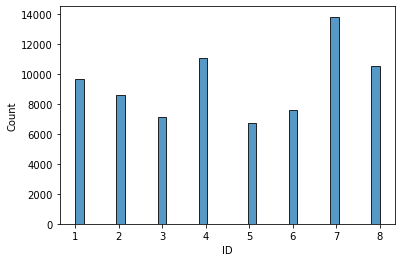

In [6]:
import seaborn as sns

sns.histplot(data=data_features, x="ID")

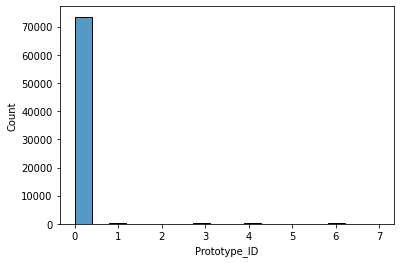

In [ ]:
sns.histplot(data=data_features, x="Prototype_ID")

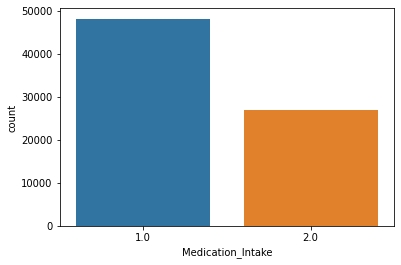

In [ ]:
sns.countplot(data=data_features, x="Medication_Intake")

##Causal Bootstrapping for sampling

In [4]:
###Adjustment for factors####
# Estimating the empirical probabilities of the different factors
# Age: 58 69 59 69 63 59 49 72 ---> categorical of above and below 65
Age = np.ones(len(data_features))
Age[data_features["ID"] == 1] = 1
Age[data_features["ID"] == 2] = 2
Age[data_features["ID"] == 3] = 1
Age[data_features["ID"] == 4] = 2
Age[data_features["ID"] == 5] = 1
Age[data_features["ID"] == 6] = 1
Age[data_features["ID"] == 7] = 1
Age[data_features["ID"] == 8] = 2
# Time since diagnosis: 8 10 6 8 6 4 5 13 --->  Categorical of more or less then 7 years since diagnosis 
TimeDiagnose = np.ones(len(data_features))
TimeDiagnose[data_features["ID"] == 1] = 2
TimeDiagnose[data_features["ID"] == 2] = 2
TimeDiagnose[data_features["ID"] == 3] = 1
TimeDiagnose[data_features["ID"] == 4] = 2
TimeDiagnose[data_features["ID"] == 5] = 1
TimeDiagnose[data_features["ID"] == 6] = 1
TimeDiagnose[data_features["ID"] == 7] = 1
TimeDiagnose[data_features["ID"] == 8] = 2
# Probability of tremor ON per age group p(T|A)

# Categorize tremor prototypes
proto_len = np.sum(data_features["Prototype_ID"] != 0)
Tremor_proto = np.ones(len(data_features))
Tremor_proto[data_features["Prototype_ID"] == 1] = 1
Tremor_proto[data_features["Prototype_ID"] == 2] = 1
Tremor_proto[data_features["Prototype_ID"] == 3] = 2
Tremor_proto[data_features["Prototype_ID"] == 4] = 2
Tremor_proto[data_features["Prototype_ID"] == 5] = 3
Tremor_proto[data_features["Prototype_ID"] == 6] = 4
Tremor_proto[data_features["Prototype_ID"] == 7] = 4

Tremor_arm_rest = np.ones(len(data_features))
Tremor_arm_rest[data_features["Prototype_ID"] == 1] = 1
Tremor_arm_rest[data_features["Prototype_ID"] == 3] = 1
Tremor_arm_rest[data_features["Prototype_ID"] == 6] = 1

Tremor_arm_rest[data_features["Prototype_ID"] == 2] = 2
Tremor_arm_rest[data_features["Prototype_ID"] == 4] = 2
Tremor_arm_rest[data_features["Prototype_ID"] == 7] = 2

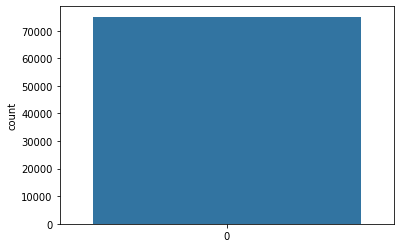

In [ ]:
sns.countplot(data=Age)

In [5]:
from sklearn.ensemble import RandomForestClassifier

Ind_proto_known = data_features["Prototype_ID"] != 0
X_proto_train = data_features[Ind_proto_known]
X_proto_train = X_proto_train.drop(columns=["Prototype_ID", "Medication_Intake", "ID", "Non-tremor/Tremor"])
y_proto_train = data_features["Prototype_ID"][Ind_proto_known]

Ind_proto_unknown = data_features["Prototype_ID"] == 0
X_proto_test = data_features[Ind_proto_unknown]
X_proto_test = X_proto_test.drop(columns=["Prototype_ID", "Medication_Intake", "ID", "Non-tremor/Tremor"])

rf = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced")
# Train the model on training data
rf.fit(X_proto_train, y_proto_train);
predictions_proto = rf.predict(X_proto_test)
prob_predictions_proto = rf.predict_proba(X_proto_test)
y_proto = data_features["Prototype_ID"]
y_proto[Ind_proto_unknown] = predictions_proto
data_features["Prototype_ID"][Ind_proto_unknown] = predictions_proto

y_proto_group_train = Tremor_proto
y_proto_group_train = y_proto_group_train[Ind_proto_known]
rf = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced")
rf.fit(X_proto_train, y_proto_group_train);
predictions_proto_group = rf.predict(X_proto_test)
prob_predictions_proto_group = rf.predict_proba(X_proto_test)
y_proto_group = Tremor_proto
y_proto_group[Ind_proto_unknown] = predictions_proto_group
Tremor_proto[Ind_proto_unknown] = predictions_proto_group

y_arm_rest_train = Tremor_arm_rest
y_arm_rest_train = y_arm_rest_train[Ind_proto_known]
rf = RandomForestClassifier(n_estimators = numestimators, random_state = 0, class_weight="balanced")
rf.fit(X_proto_train, y_arm_rest_train);
predictions_arm_rest = rf.predict(X_proto_test)
prob_predictions_arm_rest = rf.predict_proba(X_proto_test)
y_arm_rest = Tremor_arm_rest
y_arm_rest[Ind_proto_unknown] = predictions_arm_rest
Tremor_arm_rest[Ind_proto_unknown] = predictions_arm_rest

Tremor_on_off = np.zeros(len(data_features))
Tremor_on_off[data_features["Non-tremor/Tremor"]==1] = 1
Tremor_on_off[data_features["Non-tremor/Tremor"]==0] = 0

In [5]:
joint_probs = data_features.value_counts(["ID", "Medication_Intake"], normalize=True)
print(joint_probs)

ID   Medication_Intake
7.0  1.0                  0.115648
4.0  1.0                  0.096842
8.0  1.0                  0.090529
1.0  1.0                  0.077596
2.0  1.0                  0.073814
3.0  1.0                  0.070910
7.0  2.0                  0.068486
6.0  1.0                  0.066102
1.0  2.0                  0.050892
4.0  2.0                  0.050705
5.0  1.0                  0.049813
8.0  2.0                  0.049600
2.0  2.0                  0.040836
5.0  2.0                  0.039504
6.0  2.0                  0.034736
3.0  2.0                  0.023987
dtype: float64


In [ ]:
def kron_delt(a):
  if type(a) == int:
    if a == 0:
      return 1
    else:
      return 0
  else:
    result = np.zeros(len(a))
    for i in range(len(a)):
      if a[i] == 0:
        result[i] = 1
      else:
        result[i] = 0
    return result

In [6]:
p_med_n = np.zeros(len(data_features))
p_age_n = np.zeros(len(data_features))
p_proto_given_t_n = np.zeros(len(data_features))
p_p_a_m_t = np.zeros(len(data_features))
p_t_given_a_n = np.zeros(len(data_features))
w_n = np.zeros(len(data_features))

for n in range(len(data_features)):
    p_med_n[n] = np.sum(data_features["Medication_Intake"] == data_features["Medication_Intake"][n])/len(data_features)    
    p_age_n[n] = np.sum(Age == Age[n])/len(data_features)
    p_t_given_a_n[n] = np.sum(Tremor_on_off[Age == Age[n]] == 1)/np.sum(Tremor_on_off == 1)
    p_proto_given_t_n[n] = np.sum(Tremor_proto[Tremor_on_off == Tremor_on_off[n]] == Tremor_proto[n])/np.sum(Tremor_on_off == 1)
    ind_med = data_features["Medication_Intake"][Tremor_proto==Tremor_proto[n]] == data_features["Medication_Intake"][n]
    data_temp_proto = data_features["Non-tremor/Tremor"][Tremor_proto==Tremor_proto[n]]
    age_temp = Age[Tremor_proto==Tremor_proto[n]]
    data_temp_proto = data_temp_proto[ind_med]
    p_p_a_m_t[n] = np.sum(data_temp_proto[age_temp[ind_med] == Age[n]]==1)/len(data_features)
    w_n[n] = p_med_n[n]*p_age_n[n]*p_t_given_a_n[n]*p_proto_given_t_n[n]/p_p_a_m_t[n]

n_sample = len(data_features)
ind_data_bootstrap = np.random.choice(range(len(data_features)), size = n_sample, replace=True, p = w_n/np.sum(w_n))
     
Y_features_controlled = Y_features_final[ind_data_bootstrap,:]
data_features_bs = pd.DataFrame(data=Y_features_controlled, columns=["ID", "Col2", "Col3", "Col4", "Col5", "Col6", "Col7", "Col8", "Col9", "Col10","Col11", "Col12", "Col13", "Col14", "Col15", 
                                                                     "Col16", "Col17", "Col18", "Col19", "Col20", "Col21", "Col22", "Col23", "Col24", "Medication_Intake","Prototype_ID",
                                                                     "Non-tremor/Tremor","Activity_label"])

In [7]:
data_features_bs_id = data_features_bs.drop(columns=["Prototype_ID", "Medication_Intake", "Activity_label"])

...1 processing complete
...2 processing complete
...4 processing complete
...7 processing complete
...5 processing complete
...3 processing complete
...8 processing complete
...6 processing complete
Sensitivity: 0.8404149625442432 | Specificity: 0.6846350657296347
Results for Naive LOOCV using IDs as folds with a Logistic Regression Classifier:
 {'err_hat': 0.152235585567587, 'ci_lo': 0.15007904359578814, 'ci_hi': 0.1543921275393859, 'sd': 0.3592490947162997}


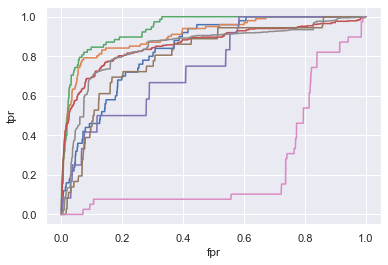

In [80]:
from sklearn import metrics

clf1 = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced")
clf2 = LogisticRegression(class_weight="balanced", random_state=0, solver="newton-cg")

naive_loocv_id_logreg_results = naive_loocv(data_features_bs_id, clf2, idcolumn)
print("Results for Naive LOOCV using IDs as folds with a Logistic Regression Classifier:\n {}".format(naive_loocv_id_logreg_results))

...1 processing complete
...7 processing complete
...8 processing complete
...4 processing complete
...6 processing complete
...3 processing complete
...5 processing complete
...2 processing complete
Sensitivity: 0.5437425042558626 | Specificity: 0.8319833466221407
Results for Naive LOOCV using IDs as folds with a Random Forest Classifier:
 {'err_hat': 0.019925147507358718, 'ci_lo': 0.01908628143828742, 'ci_hi': 0.020764013576430016, 'sd': 0.13974310717945526}


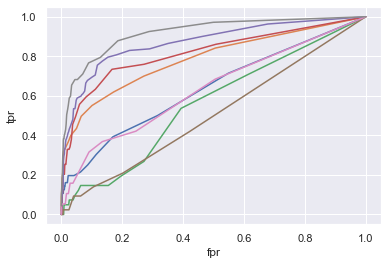

In [22]:
naive_loocv_id_rf_results = naive_loocv(data_features_bs_id, clf1, idcolumn)
print("Results for Naive LOOCV using IDs as folds with a Random Forest Classifier:\n {}".format(naive_loocv_id_rf_results))

Sensitivity: 0.9114284610602599 | Specificity: 0.9474602633491978
Results for Naive 10-fold with a Random Forest Classifier:
 {'err_hat': 0.007858179832447623, 'ci_lo': 0, 'ci_hi': 0, 'sd': 0.08829738864863748}


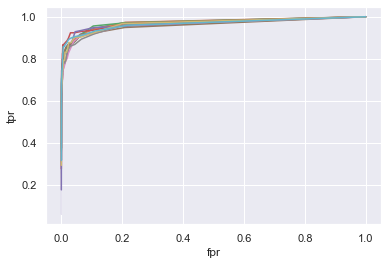

In [85]:
naive_10fold_id_rf_results = naive_tenfoldcv(data_features_bs_id, clf1, idcolumn)
print("Results for Naive 10-fold with a Random Forest Classifier:\n {}".format(naive_10fold_id_rf_results))

Sensitivity: 0.7821868972359809 | Specificity: 0.8955522803034898
Results for Naive 10-fold with a Logistic Regression Classifier:
 {'err_hat': 0.14056818635873256, 'ci_lo': 0, 'ci_hi': 0, 'sd': 0.34757556206176116}


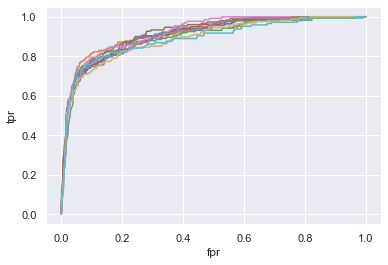

In [84]:
naive_10fold_id_logreg_results = naive_tenfoldcv(data_features_bs_id, clf2, idcolumn)
print("Results for Naive 10-fold with a Logistic Regression Classifier:\n {}".format(naive_10fold_id_logreg_results))

In [48]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

naive_loocv_id_logreg_results = naive_loocv(data_features_id, clf2, idcolumn)
print("Results for Naive LOOCV using IDs as folds with a Logistic Regression Classifier:\n {}".format(naive_loocv_id_logreg_results))

nested_loocv_id_logreg_results = nested_loocv(data_features_id, clf2, idcolumn, reps=5, bias_reps=2)
print("\nResults for Nested LOOCV using IDs as folds with a Logistic Regression Classifier:\n {}".format(nested_loocv_id_logreg_results))

...1 processing complete
...2 processing complete
...3 processing complete
...4 processing complete
...5 processing complete
...6 processing complete
...7 processing complete
...8 processing complete
Results for Naive LOOCV using IDs as folds with a Logistic Regression Classifier:
 {'err_hat': 0.18309559009602963, 'ci_lo': 0.18077399330364438, 'ci_hi': 0.18541718688841488, 'sd': 0.38674487066206364}
...0 rep completed!
...1 rep completed!
...2 rep completed!
...3 rep completed!
...4 rep completed!
...1 processing complete
...2 processing complete
...3 processing complete
...4 processing complete
...5 processing complete
...6 processing complete
...7 processing complete
...8 processing complete
...0 bias rep completed!
...1 processing complete
...2 processing complete
...3 processing complete
...4 processing complete
...5 processing complete
...6 processing complete
...7 processing complete
...8 processing complete
...1 bias rep completed!

Results for Nested LOOCV using IDs as folds wi

In [ ]:
naive_loocv_id_rf_results = naive_loocv(data_features_id, clf1, idcolumn)
print("Results for Naive LOOCV using IDs as folds with a Random Forest Classifier:\n {}".format(naive_loocv_id_rf_results))

nested_loocv_id_rf_results = nested_loocv(data_features_id, clf1, idcolumn, reps=1, bias_reps=1)
print("\nResults for Nested LOOCV using IDs as folds with a Random Forest Classifier:\n {}".format(nested_loocv_id_rf_results))

...1 processing complete
...2 processing complete
...3 processing complete
...4 processing complete
...5 processing complete
...6 processing complete
...7 processing complete
...8 processing complete
Results for Naive LOOCV using IDs as folds with a Random Forest Classifier:
 {'err_hat': 0.10034496077569559, 'ci_lo': 0.09854132838988099, 'ci_hi': 0.10214859316151019, 'sd': 0.30045939762739937}
...0 rep completed!
...1 processing complete
...2 processing complete
...3 processing complete
...4 processing complete
...5 processing complete
...6 processing complete
...7 processing complete
...8 processing complete
...0 bias rep completed!

Results for Nested LOOCV using IDs as folds with a Random Forest Classifier:
 {'sd_infl': 2.8284271247461903, 'err_hat': 0.10016452748799984, 'ci_lo': 0.09505681694378951, 'ci_hi': 0.10527223803221017, 'raw_mean': 0.10062275599495402, 'bias_est': 0.00045822850695417843, 'sd': 0.3008285507908682, 'running_sd_inf1': array([66.51767755])}


In [ ]:
naive_tenfoldcv_logreg_result = naive_tenfoldcv(data_features_cols, clf2)
print("Results for Naive 10-fold CV with a Logistic Regression Classifier:\n {}".format(naive_tenfoldcv_logreg_result))

nested_tenfoldcv_logreg_result = nested_tenfoldcv(data_features_cols, clf2, reps=5, bias_reps=2)
print("\nResults for Nested 10-fold CV with a Logistic Regression Classifier:\n {}".format(nested_tenfoldcv_logreg_result))

Results for Naive 10-fold CV with a Logistic Regression Classifier:
 {'err_hat': 0.1756902545251129, 'ci_lo': 0.17340580647787454, 'ci_hi': 0.17797470257235123, 'sd': 0.38055642024542685}
...0 rep completed!
...1 rep completed!
...2 rep completed!
...3 rep completed!
...4 rep completed!
...0 bias rep completed!
...1 bias rep completed!

Results for Nested 10-fold CV with a Logistic Regression Classifier:
 {'sd_inf1': 1, 'err_hat': 0.17558635669945558, 'ci_lo': 0.17330018724488885, 'ci_hi': 0.1778725261540223, 'raw_mean': 0.1760270526253478, 'bias_est': 0.0004406959258922283, 'sd': 0.38084318212274826, 'running_sd_inf1': array([0., 0., 0., 0., 0.])}


In [ ]:
naive_tenfoldcv_rf_result = naive_tenfoldcv(data_features_cols, clf1)
print("Results for Naive 10-fold CV with a Random Forest Classifier:\n {}".format(naive_tenfoldcv_rf_result))

nested_tenfoldcv_rf_result = nested_tenfoldcv(data_features_cols, clf1, reps=1, bias_reps=1)
print("\nResults for Nested 10-fold CV with a Random Forest Classifier:\n {}".format(nested_tenfoldcv_rf_result))

Results for Naive 10-fold CV with a Random Forest Classifier:
 {'err_hat': 0.068046509769449, 'ci_lo': 0.06653482137343318, 'ci_hi': 0.06955819816546481, 'sd': 0.2518256982074015}
...0 rep completed!
...0 bias rep completed!

Results for Nested 10-fold CV with a Random Forest Classifier:
 {'sd_inf1': 1, 'err_hat': 0.06693676623305594, 'ci_lo': 0.06542128059978838, 'ci_hi': 0.0684522518663235, 'raw_mean': 0.0684159119161783, 'bias_est': 0.0014791456831223548, 'sd': 0.2524582637048271, 'running_sd_inf1': array([0.])}


In [ ]:
%load_ext rpy2.ipython

In [ ]:
!pip install pymer4

     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for pymer4: filename=pymer4-0.7.4-py2.py3-none-any.whl size=58113 sha256=b421c629f06883623e8f97f197035f552bd2bbcb8069c8b1e38e01467d7a2b49
  Stored in directory: /root/.cache/pip/wheels/64/60/91/7e25b69b0a8cbd93ac4ef749764cb3f9edab88c1554a6b1867
Successfully built pymer4


In [ ]:
%%R

install.packages("lme4")

In [ ]:
from pymer4.models import Lmer

formula = "Tremor ~ Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+MedIntake+(1|ID)"

#model doesn't work with variable names including special characters
data_features_me = data_features.rename(columns={outcomevar: "Tremor", "Medication_Intake": "MedIntake"})

naive_tenfoldcv_me_result = naive_tenfoldcv(data_features_me, mixed_effects=True)
print("Results for Naive 10-fold CV with a Linear Mixed Effects Classifier:\n {}".format(naive_tenfoldcv_me_result))

nested_tenfoldcv_me_result = nested_tenfoldcv(data_features_me, mixed_effects=True, reps=1, bias_reps=1)
print("\nResults for Nested 10-fold CV with a Linear Mixed Effects Classifier:\n {}".format(nested_tenfoldcv_me_result))

Formula: Tremor~Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+MedIntake+(1|ID)

Family: binomial	 Inference: parametric

Number of observations: 67572	 Groups: {'ID': 8.0}

Log-likelihood: -16011.718 	 AIC: 32075.435

Random effects:

           Name    Var    Std
ID  (Intercept)  1.556  1.248

No random effect correlations specified

Fixed effects:

Formula: Tremor~Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+MedIntake+(1|ID)

Family: binomial	 Inference: parametric

Number of observations: 67573	 Groups: {'ID': 8.0}

Log-likelihood: -15982.314 	 AIC: 32016.628

Random effects:

           Name    Var    Std
ID  (Intercept)  1.422  1.192

No random effect correlations specified

Fixed effects:

Formula: Tremor~Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col2

TypeError: ignored

In [ ]:
nested_tenfoldcv_me_result = nested_tenfoldcv(data_features_me, mixed_effects=True, reps=1, bias_reps=1)
print("\nResults for Nested 10-fold CV with a Linear Mixed Effects Classifier:\n {}".format(nested_tenfoldcv_me_result))

ValueError: ignored

In [ ]:
data_features_me.head()

,ID,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Medication_Intake,Prototype_ID,Tremor
0,1.0,-1.944040,1.131356,1.277944,0.279097,0.341611,0.571910,0.144659,0.278485,-0.987035,0.260292,-0.033208,-0.012584,-0.169077,0.529298,-0.113515,0.269152,-0.160174,0.400771,0.440493,0.435165,-0.248497,-0.117822,0.076309,1.0,1.0,0.0
1,1.0,-2.034009,1.090760,1.227388,0.337773,0.541015,0.618601,0.299512,0.520926,-1.015866,-0.000249,-0.027141,-0.015049,-0.587413,0.329254,0.209908,-0.004192,-0.802576,-0.210874,-0.412455,0.112200,-0.082551,-0.175117,0.075088,1.0,1.0,0.0
2,1.0,-1.974930,1.117994,1.293858,0.279000,0.377537,0.588862,0.149982,0.283398,-0.983628,0.286693,-0.048148,-0.018781,-0.162478,0.537190,-0.103189,0.276877,-0.162642,0.389239,0.446490,0.430650,-0.255258,-0.102126,0.100778,1.0,1.0,0.0
3,1.0,-1.975794,1.213198,1.321256,0.484464,0.329827,-0.067854,0.443154,0.439187,0.475582,-0.088402,-0.844801,-0.885404,0.657901,-1.430833,0.953197,0.501913,1.152320,-0.456222,-0.171176,0.508072,0.253558,-0.093000,0.105604,1.0,1.0,0.0
4,1.0,2.347184,-1.852411,-0.778825,-0.641980,-2.388623,-0.693829,-0.710589,-1.604259,-0.590163,3.232919,1.562185,0.261892,1.038172,-1.333174,-0.045167,-0.401749,0.461114,-0.568264,-0.808578,1.163295,0.030349,-0.070314,-1.712010,1.0,2.0,0.0


In [8]:
import matplotlib.pyplot as plt

In [49]:
clf1 = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced")
clf2 = LogisticRegression(class_weight="balanced", random_state=0, solver="newton-cg")

clf1.fit(data_features_bs.drop(columns=["Prototype_ID", "ID", "Medication_Intake"]).iloc[:,1:24], data_features_bs[outcomevar])
clf2.fit(data_features_bs.drop(columns=["Prototype_ID", "ID", "Medication_Intake"]).iloc[:,1:24], data_features_bs[outcomevar])

LogisticRegression(class_weight='balanced', random_state=0, solver='newton-cg')

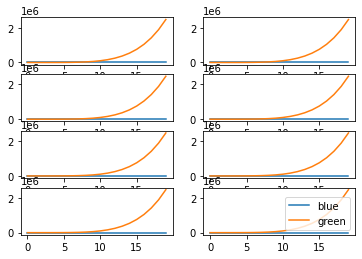

In [44]:
graphpos = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
fig, axs = plt.subplots(4,2)

for ind, i in enumerate(graphpos):
    x = np.arange(20)
    axs[i].plot(x * 4)
    axs[i].plot(x ** 5)
    plt.legend(["blue", "green"], loc ="lower right")


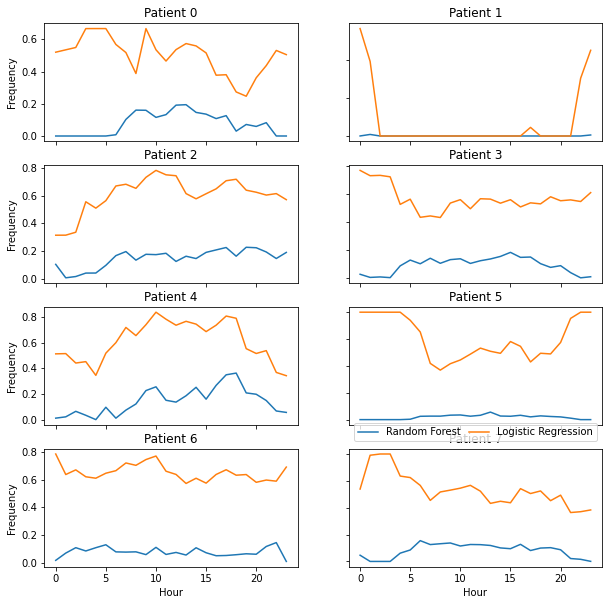

In [53]:
files = ['02', '12', '13', '17', '18', '22', '23', '38']
hours = np.arange(24)
fig, axs = plt.subplots(4,2)
countersrf = np.zeros((24, 8))
counterslog = np.zeros((24, 8))

fig.set_figheight(10)
fig.set_figwidth(10)

for ind, i in enumerate(files):
    fps_file = 'C:\\Users\Sam\Documents\Msc Project\Features_per_second_hbv0{}.mat'.format(i)
    fps_contents = sio.loadmat(fps_file)
    fps_features = fps_contents['accel_features_hbv0{}'.format(i)];
    
    fps_features_whiten = fps_features[:,:45]
    fps_features_whiten = fps_features_whiten - np.mean(fps_features_whiten,axis=0)
    fps_features_whiten = pca.transform(fps_features_whiten)

    fps_data = np.concatenate((fps_features_whiten, fps_features[:,45:]), axis=1)
    
    fps_df = pd.DataFrame(data=fps_data, columns=["Col2", "Col3", "Col4", "Col5", "Col6", "Col7", "Col8", "Col9", "Col10",
                                                  "Col11", "Col12", "Col13", "Col14", "Col15", "Col16", "Col17", "Col18", 
                                                  "Col19", "Col20", "Col21", "Col22", "Col23", "Col24", "time1", "time2"])
    
    fps_df["hour"] = np.array([int(24*round(i - int(i), 3)) for i in fps_df["time1"]])
    
    for h in hours:
        time_df = fps_df[fps_df["hour"] == h]
        X = time_df.drop(columns=["time1", "time2", "hour"])
        probs_t_rf = clf1.predict_proba(X)[:,1]
        countersrf[h, ind] = sum(j > 0.8 for j in probs_t_rf) / len(probs_t_rf)
        probs_t_log = clf2.predict_proba(X)[:,1]
        counterslog[h, ind] = sum(j > 0.8 for j in probs_t_log) / len(probs_t_log)

graphpos = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
for ind, i in enumerate(graphpos):
    axs[i].plot(hours, countersrf[:,ind])
    axs[i].plot(hours, counterslog[:,ind])
    axs[i].set_title("Patient {}".format(ind))
    plt.legend(["Random Forest", "Logistic Regression"], bbox_to_anchor=(0, 1.02, 1, 0.2), 
               loc ="lower left", mode="expand", ncol=3)
    
for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Frequency')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Text(0.5, 1.0, 'Tremor frequency per hour, RF')

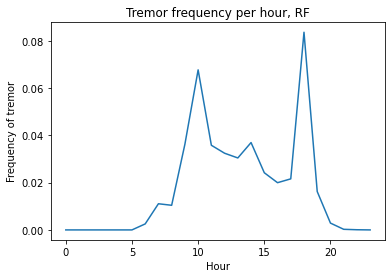

In [51]:
plt.plot(hours, countersrf)
plt.xlabel("Hour")
plt.ylabel("Frequency of tremor")
plt.title("Tremor frequency per hour, RF")

Text(0.5, 1.0, 'Tremor frequency per hour, LogReg')

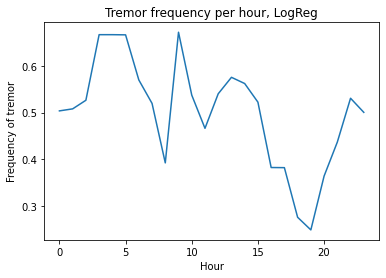

In [52]:
plt.plot(hours, counterslog)
plt.xlabel("Hour")
plt.ylabel("Frequency of tremor")
plt.title("Tremor frequency per hour, LogReg")

In [59]:
fps2_df["hour"] = np.array([fps2_df["timestamp"].iloc[i].hour for i in range(len(fps2_df))])
countersrf2 = np.zeros(24)
counterslog2 = np.zeros(24)
for i in hours:
    time2_df = fps2_df[fps2_df["hour"] == i]
    X2 = time2_df.drop(columns=["time1", "time2", "timestamp", "hour"])
    probs_rf_t2 = clf1.predict_proba(X2)[:,1]
    countersrf2[i] = sum(j > 0.8 for j in probs_rf_t2) / len(probs_rf_t2)
    probs_log_t2 = clf2.predict_proba(X2)[:,1]
    counterslog2[i] = sum(j > 0.8 for j in probs_log_t2) / len(probs_log_t2)

Text(0.5, 1.0, 'Tremor frequency per hour, Data 2')

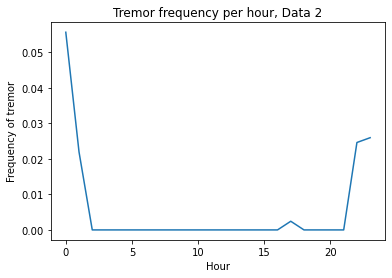

In [60]:
plt.plot(hours, countersrf2)
plt.xlabel("Hour")
plt.ylabel("Frequency of tremor")
plt.title("Tremor frequency per hour, Data 2")

Text(0.5, 1.0, 'Tremor frequency per hour, Data 2')

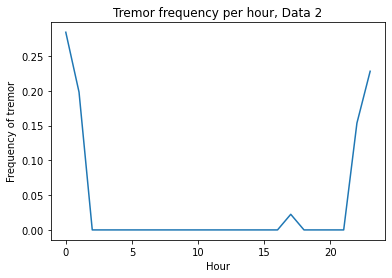

In [61]:
plt.plot(hours, counterslog2)
plt.xlabel("Hour")
plt.ylabel("Frequency of tremor")
plt.title("Tremor frequency per hour, Data 2")